In [1]:
import numpy as np
import torch.nn as nn
import torch
from matplotlib import pyplot as plt

import mediapy as media

torch.autograd.set_detect_anomaly(True)

In [34]:
num_steps = 6000


def create_noisy_line(x, var):
    y = 5.76 * x + 3.0 + torch.randn(x.shape, device="cuda") * var
    y2 = -2.1 * x + 27.0 + torch.randn(x.shape, device="cuda") * var

    torch.autograd.set_detect_anomaly(True)

    idx_pari = torch.arange(0, y.shape[0], 1, device="cuda") % 2 == 0
    # print(idx_pari.shape)
    y[idx_pari] = y2[idx_pari]

    idx = torch.randint(0, 10, y.shape) > 6
    y[idx] = y[idx] + torch.randint(-20, 20, y.shape, device="cuda")[idx]

    return y


def create_x_axis(n_points):
    x = torch.linspace(0, 10, n_points, device="cuda")
    return x


def create_normal(params):
    normal = torch.stack(
        (params[0, 0].unsqueeze(0), torch.tensor([-1.0], device="cuda")), dim=0
    )
    normal = normal / torch.norm(normal, p=2)
    return normal


def calculate_alpha(step):

    if step >= num_steps * 0.6:
        return torch.tensor([-1], device="cuda")
    else:
        alpha = -4 - round(step / num_steps, 1) * 10

    alpha = torch.tensor([alpha], device="cuda")
    return alpha


def choose_c(step, cmax, cmin):

    c = cmax - (cmax - cmin) * min(
        torch.tensor([step / 4000], device="cuda"),
        torch.tensor([1], device="cuda"),
    )

    return c


def robust_loss(residuals, step, cmin, cmax):

    c = choose_c(step, cmax, cmin)

    a = calculate_alpha(step)

    if a.item() == -1:

        loss = 1 - torch.exp(-0.5 * (residuals / c) ** 2)

    else:
        t = ((residuals / c) ** 2 / torch.abs(a - 2)) + 1
        t1 = torch.pow(t, a / 2) - 1
        loss = t1 * torch.abs(a - 2) / a

    idx_inliers = loss / (0.5 * (residuals / c) ** 2) > 0.8

    return idx_inliers, loss


class RobustFitter(nn.Module):

    def __init__(self, params, normal):
        super().__init__()
        self.params = nn.Parameter(params, requires_grad=True)
        self.normal = normal

        # dict_params = [{"params": [self.params], "lr": 0.1, "eps": 1e-08}]

        self.optimizer = torch.optim.Adam(params=[self.params], lr=0.1, eps=1e-08)

        self.scheduler = torch.arange(0.001, 3000, 0.00001, device="cuda")

    def forward(self, x):
        return self.params[0] * x + self.params[1]

    def adjust(self):

        normal_new = torch.stack(
            (self.params[0, 0].unsqueeze(0), torch.tensor([-1.0], device="cuda")), dim=0
        )
        normal_new = normal_new / torch.norm(normal_new, p=2)
        self.normal = normal_new

    def loss(self, v_true, v_pred, cmin, cmax, step):

        residual = (v_pred - v_true) @ self.normal
        residual = torch.norm(residual, p=1, dim=1)

        idx_inliers, loss = robust_loss(residual, step, cmin, cmax)
        # residual = 1- torch.exp(-0.5*(residual/c)**2)
        loss = torch.sum(loss, dim=0)

        return idx_inliers, loss

        """
        print(residual.shape)

        if step>threshold:
            residual = 1- torch.exp(-0.5*(residual/c)**2)
        else:
            t=(residual/c)**2
            residual = -2*((4/(t + 4)) - 1)
        
        print(residual)

        
        residual2 = torch.zeros(residual.shape, device='cuda')
        idx= residual > 0.0001
        residual2[idx]= torch.sqrt(residual[idx]) 
        residual2[~idx]= torch.sqrt(residual[~idx]**2 + 1e-6) 
        #residual = torch.sqrt(residual) """

    def updatelr(self, step):
        for group in self.optimizer.param_groups:
            group["lr"] = self.scheduler[step].item()
            print(self.scheduler[step])

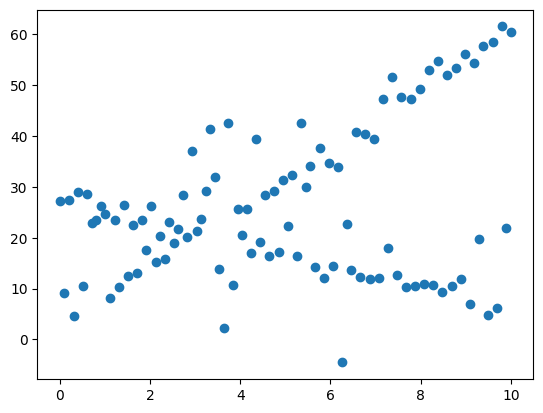

In [35]:
x = create_x_axis(100)

y = create_noisy_line(x, var=1.5)

plt.scatter(x.cpu(), y.cpu())

plt.show()

In [37]:
params = torch.tensor([[0.0], [10.0]], device="cuda")

cmin = torch.tensor([1.5], device="cuda")

cmax = torch.tensor([2.5], device="cuda")

normal = create_normal(params)

fitter = RobustFitter(params, normal)

vec_true = torch.cat((x.unsqueeze(-1), y.unsqueeze(-1)), dim=1)


num_steps = 6000

output_path = "output/"


for step in range(num_steps):

    y_pred = fitter(x.unsqueeze(-1))
    vec_pred = torch.cat((x.unsqueeze(-1), y_pred), dim=1)
    idx_inlier, loss = fitter.loss(vec_true, vec_pred, cmin=cmin, cmax=cmax, step=step)
    print(loss)

    if torch.isnan(loss):
        break

    fitter.optimizer.zero_grad()
    loss.backward()

    fitter.optimizer.step()

    print(fitter.params)
    print(loss.item())
    print("---")
    fitter.adjust()
    fitter.updatelr(step)

    if step % 30 == 0:
        idx_inlier = idx_inlier.cpu()
        plt.scatter(x.cpu()[idx_inlier], y.cpu()[idx_inlier], c="g")
        plt.scatter(x.cpu()[~idx_inlier], y.cpu()[~idx_inlier], c="r")
        plt.plot(x.cpu(), y_pred.detach().cpu(), c="b")
        # plt.plot(x.cpu(), y_pred2.detach().cpu(), c='y', scalex=4, scaley=4)
        # plt.show()
        plt.savefig(output_path + "test" + str(step) + ".png")
        plt.close()

conv1 = fitter.params.detach().cpu().numpy()
print(fitter.normal)
print(conv1)

print("---")
print("---")

tensor(125.1404, device='cuda:0', grad_fn=<SumBackward1>)
Parameter containing:
tensor([[ 0.1000],
        [10.1000]], device='cuda:0', requires_grad=True)
125.14036560058594
---
tensor(0.0010, device='cuda:0')
tensor(122.6727, device='cuda:0', grad_fn=<SumBackward1>)
Parameter containing:
tensor([[ 0.1009],
        [10.1010]], device='cuda:0', requires_grad=True)
122.67268371582031
---
tensor(0.0010, device='cuda:0')
tensor(122.6562, device='cuda:0', grad_fn=<SumBackward1>)
Parameter containing:
tensor([[ 0.1019],
        [10.1019]], device='cuda:0', requires_grad=True)
122.65618896484375
---
tensor(0.0010, device='cuda:0')
tensor(122.6399, device='cuda:0', grad_fn=<SumBackward1>)
Parameter containing:
tensor([[ 0.1029],
        [10.1029]], device='cuda:0', requires_grad=True)
122.63985443115234
---
tensor(0.0010, device='cuda:0')
tensor(122.6235, device='cuda:0', grad_fn=<SumBackward1>)
Parameter containing:
tensor([[ 0.1038],
        [10.1039]], device='cuda:0', requires_grad=True)


KeyboardInterrupt: 

In [33]:
VIDEO = "output/" + "video.mp4"


def create_video():

    with media.VideoWriter(
        VIDEO, shape=(512, 512), fps=30, input_format="rgb"
    ) as video:
        for step in range(num_steps):
            if step % 30 == 0:
                img = media.read_image(output_path + "test" + str(step) + ".png")
                img = media.resize_image(img, (512, 512))
                video.add_image(img[:, :, :3])


create_video()

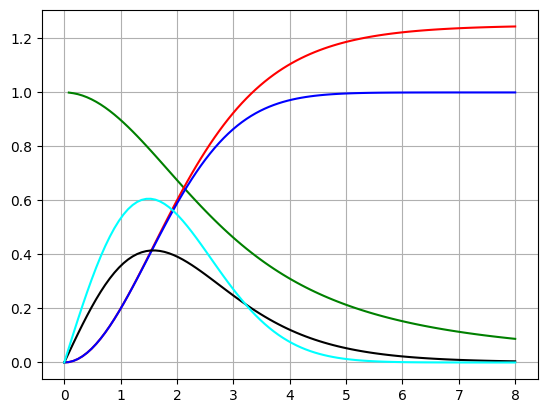

In [90]:
def robust_loss(residuals):

    c = torch.tensor([1.5], device="cuda")

    a = torch.tensor([-8], device="cuda")

    if a.item() == -1:

        loss = 1 - torch.exp(-0.5 * (residuals / c) ** 2)

    else:
        t = ((residuals / c) ** 2 / torch.abs(a - 2)) + 1
        t1 = torch.pow(t, a / 2) - 1
        loss = t1 * torch.abs(a - 2) / a

    # idx_inliers = (loss / 0.5 * (residuals / c) ** 2) > 1

    return loss


residual = torch.linspace(0, 8, 100, device="cuda", requires_grad=True)
optimizer = torch.optim.Adam([residual], lr=0.1, eps=1e-08)

loss = robust_loss(residual)
loss_tot = torch.sum(loss)
loss_tot.backward()

c_cpu = 1.5


ratio = loss.cpu() / (0.5 * (residual.cpu() / c_cpu) ** 2)

grad = (residual / c_cpu) * torch.exp(-0.5 * (residual / c_cpu) ** 2)
plt.plot(residual.detach().cpu(), ratio.detach().cpu(), c="green")
plt.plot(residual.detach().cpu(), loss.detach().cpu(), c="red")
plt.plot(
    residual.detach().cpu(),
    1 - torch.exp(-0.5 * (residual / 1.5) ** 2).detach().cpu(),
    c="blue",
)
plt.plot(residual.detach().cpu(), residual.grad.cpu(), c="black")
plt.plot(residual.detach().cpu(), grad.detach().cpu(), c="cyan")
plt.grid()
plt.show()